In [3]:
import pandas as pd
from ggplot import *

project_id = "the-d-team-164512"

query = """\
SELECT
    c.ChronicIllness AS illness
    , count(*) AS transaction_count
FROM [the-d-team-164512:dthon.transactions] t
JOIN [the-d-team-164512:dthon.chronic_illness_lookup] c
    ON t.Drug_ID = c.MasterProductID
GROUP BY
    illness
ORDER BY
    transaction_count DESC
"""

df_illness = pd.read_gbq(query, project_id)
df_illness

Waiting for job to complete...


,illness,transaction_count
0,Lipids,10165664
1,Hypertension,6619162
2,Depression,4439029
3,Diabetes,3618724
4,Heart Failure,3368392
5,Epilepsy,1112880
6,Chronic Obstructive Pulmonary Disease (COPD),879917
7,Osteoporosis,546735
8,Anti-Coagulant,404663
9,Urology,247944


In [4]:
query = """\
SELECT
    p.year_of_birth AS year_of_birth
    , p.gender AS gender
    , c.ChronicIllness AS illness
    , count(*) AS transaction_count
FROM [the-d-team-164512:dthon.transactions] t
    JOIN [the-d-team-164512:dthon.chronic_illness_lookup] c
    ON t.Drug_ID = c.MasterProductID
    JOIN [the-d-team-164512:dthon.patients_lookup] p
    ON t.Patient_ID = p.Patient_ID
WHERE
    p.year_of_birth != 1900
GROUP BY
    year_of_birth
    , gender
    , illness
"""
df_illness_yob = pd.read_gbq(query, project_id)
df_illness_yob.head(3)

Waiting for job to complete...


,year_of_birth,gender,illness,transaction_count
0,1946,M,Lipids,7647
1,1934,M,Epilepsy,629
2,1934,F,Anti-Coagulant,651


In [5]:
df_illness_yob.year_of_birth = pd.Series(df_illness_yob.year_of_birth).apply(pd.to_datetime, format='%Y')
df_illness_yob.head(3)

,year_of_birth,gender,illness,transaction_count
0,1946-01-01,M,Lipids,7647
1,1934-01-01,M,Epilepsy,629
2,1934-01-01,F,Anti-Coagulant,651


## Illness age breakdown
For the limited set of patients that have a year of birth, plot their distribution in each illness. More needs to be done here, maybe a normalisation of sorts, also is there anything particular about this subset of patients with age (location, pharmacy, disease, etc). **Depression** has a clear younger age bump and what looks like **COPD**

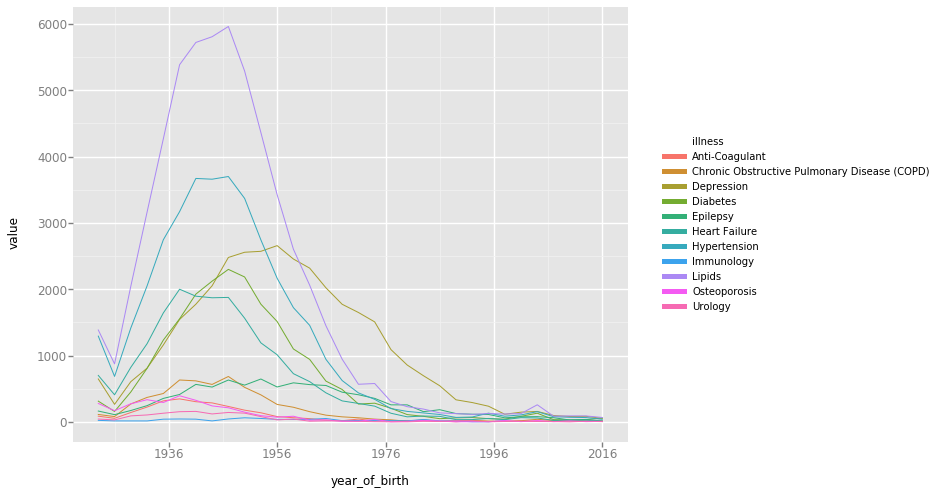

<ggplot: (-9223372036570582812)>

In [77]:
df_illness_yob_no_gender = df_illness_yob[['year_of_birth', 'illness', 'transaction_count']]
df_illness_yob_no_gender.index = df_illness_yob_no_gender.year_of_birth
df_illness_yob_no_gender = df_illness_yob_no_gender.groupby('illness').resample('3A')
df_illness_yob_no_gender.reset_index(inplace=True)

df_illness_yob_lng = pd.melt(df_illness_yob_no_gender,
                             id_vars=['year_of_birth', 'illness'], value_vars=['transaction_count'])
ggplot(
    aes(x='year_of_birth', y='value', colour='illness'),
    data=df_illness_yob_lng) +\
    geom_line()

### Attempt at normalized curve
normalized between illnesses but not the population curve? In the second plot it shows that for **Immunology** you do not have to be that old? why not? why so many peaks?

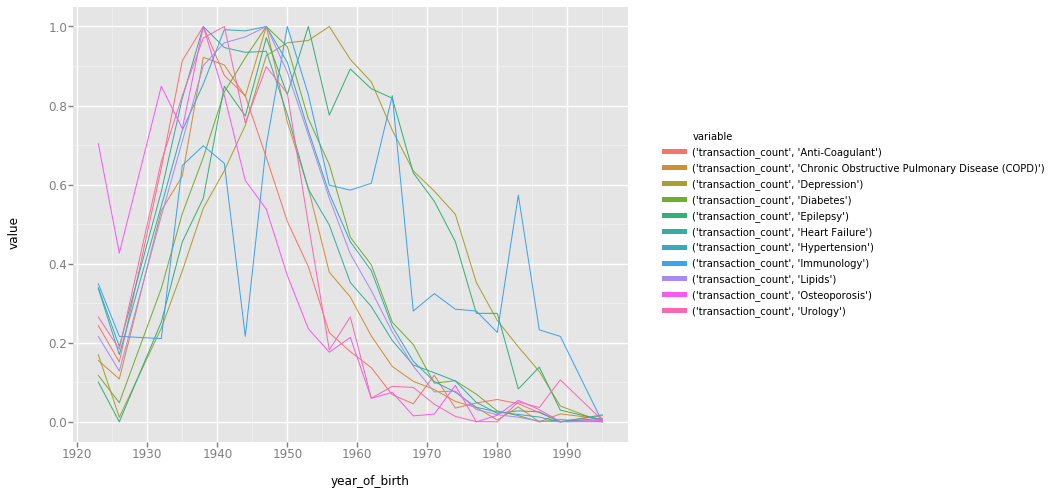

<ggplot: (286483783)>

In [97]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()

df_pivoted = df_illness_yob_no_gender.pivot(index='year_of_birth', columns='illness')
colnames = df_pivoted.columns.values
# colnames = [('transaction_count', 'Immunology'), ('transaction_count', 'Urology')]
x = df_pivoted[colnames].dropna()
df_index = x.index
x_scaled = min_max_scaler.fit_transform(x)

df = pd.DataFrame(x_scaled, columns=colnames, index=df_index)
df = df.reset_index()

df_lng = pd.melt(df, id_vars=['year_of_birth'])
ggplot(
    aes(x='year_of_birth', y='value', colour='variable'),
    data=df_lng) +\
    geom_line()

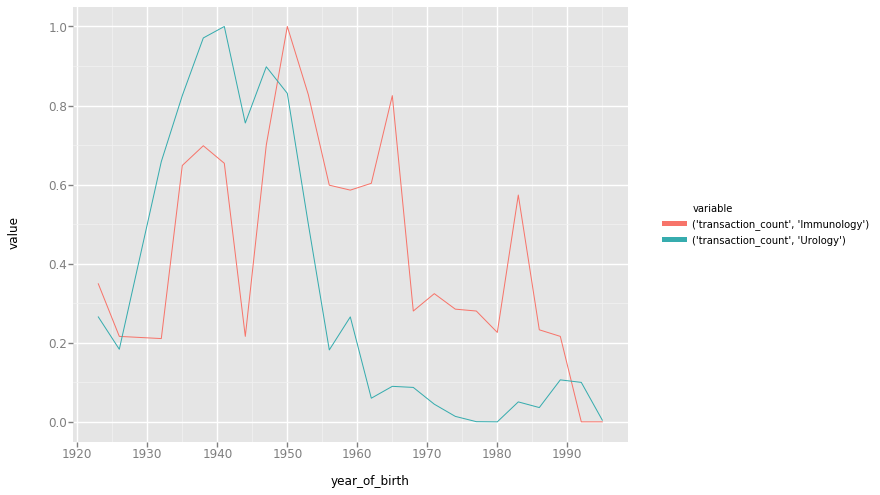

<ggplot: (-9223372036567868819)>

In [98]:
colnames = [('transaction_count', 'Immunology'), ('transaction_count', 'Urology')]
x = df_pivoted[colnames].dropna()
df_index = x.index
x_scaled = min_max_scaler.fit_transform(x)

df = pd.DataFrame(x_scaled, columns=colnames, index=df_index)
df = df.reset_index()

df_lng = pd.melt(df, id_vars=['year_of_birth'])
ggplot(
    aes(x='year_of_birth', y='value', colour='variable'),
    data=df_lng) +\
    geom_line()

## Multiple illnesses
See the illnesses that are grouped together. In this case only list the ones with more then 100 patients in that category

In [44]:
query = """\
SELECT
illnesses
, illness_count
, COUNT(patient_id) AS patient_count
FROM(
    SELECT
        t.Patient_ID AS patient_id
        , COUNT(UNIQUE(c.ChronicIllness)) AS illness_count
        , GROUP_CONCAT(UNIQUE(c.ChronicIllness)) AS illnesses
    FROM [the-d-team-164512:dthon.transactions] t
    JOIN [the-d-team-164512:dthon.chronic_illness_lookup] c
    ON t.Drug_ID = c.MasterProductID
    JOIN [the-d-team-164512:dthon.patients_lookup] p
    ON t.Patient_ID = p.Patient_ID
    WHERE
        p.year_of_birth != 1900
    GROUP BY
        patient_id
)
GROUP BY
    illnesses
    , illness_count
HAVING
    patient_count > 100
ORDER BY
    illness_count DESC
"""

df_multi_illnes = pd.read_gbq(query, project_id)
df_multi_illnes.head(10)

Waiting for job to complete...


,illnesses,illness_count,patient_count
0,"Lipids,Diabetes,Hypertension,Depression,Epilep...",6,113
1,"Lipids,Hypertension,Depression,Epilepsy,Heart ...",5,151
2,"Lipids,Diabetes,Hypertension,Depression,Epilepsy",5,140
3,"Lipids,Diabetes,Hypertension,Depression,Heart ...",5,264
4,"Lipids,Diabetes,Depression,Epilepsy,Heart Failure",5,118
5,"Lipids,Diabetes,Hypertension,Depression",4,415
6,"Lipids,Hypertension,Heart Failure,Chronic Obst...",4,129
7,"Lipids,Hypertension,Anti-Coagulant,Heart Failure",4,106
8,"Lipids,Hypertension,Depression,Chronic Obstruc...",4,110
9,"Lipids,Hypertension,Depression,Heart Failure",4,459


In [45]:
df_multi_illnes.tail(10)

,illnesses,illness_count,patient_count
49,"Depression,Chronic Obstructive Pulmonary Disea...",2,226
50,"Hypertension,Depression",2,810
51,Chronic Obstructive Pulmonary Disease (COPD),1,233
52,Heart Failure,1,483
53,Hypertension,1,1394
54,Epilepsy,1,559
55,Osteoporosis,1,121
56,Diabetes,1,224
57,Lipids,1,2018
58,Depression,1,3315
